In [1]:
#libraries
import numpy as np
import matplotlib.pyplot as plt
import requests
import pandas as pd
from scipy.optimize import minimize
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot as pl

%matplotlib inline

# I. Missing Data Prediction

In [2]:
#parse data
df = pd.read_csv('sotonmet.txt',parse_dates=[0,2])
df.drop_duplicates(subset = ['Reading Date and Time (ISO)'],keep='first',inplace=True)
y = df[['Tide height (m)']]
t = df[['Reading Date and Time (ISO)']]

# extract training/test data
ytest = y[y['Tide height (m)'].isnull()].values
ytrain = y[y['Tide height (m)'].notnull()].values
ttrain = t[y['Tide height (m)'].notnull()].values
ttest = t[y['Tide height (m)'].isnull()].values
y_test_true = df[df['Tide height (m)'].isnull()][['True tide height (m)']]
y_true = df[['True tide height (m)']]

indmu = df[['Independent tide height prediction (m)']].values
indsd = df[['Independent tide height deviation (m)']].values

dmu = df[['Dependent tide height prediction (m)']].values
dsd = df[['Dependent tide height deviation (m)']].values


In [3]:
tplot = t.values.ravel()
yplot = y.values.ravel()
#print(yy)
idplot = np.where(np.isnan(y.values.ravel())==True)

In [4]:
ids = np.where(np.isnan(y.values.ravel())==True)

In [17]:
#define kernel and covariance matrix
def exp_kernel(diff, params):
    amplitude=params[0]
    scale=params[1]
    return amplitude**2*np.exp(-(diff**2) / (2.0*scale**2))

def rq_kernel(diff, params):
    amplitude=params[0]
    scale=params[1]
    alpha = params[2]
    return amplitude**2*((1 + diff**2)/(2*alpha*scale**2))**(-alpha) 

def periodic_kernel(diff, params):
    amplitude=params[0]
    scale=params[1]
    p = params[2]
    return amplitude**2*np.exp(-(2*np.sin(np.pi*np.abs(diff)/p)**2) / scale**2)

def matern(diff,params):
    sig = params[0]
    l = params[1]
    return sig**2 *(1+ np.sqrt(3)*np.sqrt(diff**2)/l) * np.exp(-np.sqrt(3)*np.sqrt(diff**2)/l)


def matern_mix(diff,params):
    sig = params[0]
    l = params[1]
    
    amplitude=params[2]
    scale=params[3]
    p = params[4]
    
    
    return sig**2 *(1+ np.sqrt(3)*np.sqrt(diff**2)/l) * np.exp(-np.sqrt(3)*np.sqrt(diff**2)/l) + amplitude**2*np.exp(-(2*np.sin(np.pi*np.abs(diff)/p)**2) / scale**2)



#mixture models with additions

#RBF+RQ w same params
def mix_kernel_add1(diff, params):
    amplitude=params[0]
    scale=params[1]
    alpha = params[2]
    return amplitude**2*np.exp(-(diff**2) / (2.0*scale**2)) + amplitude**2*((1 + diff**2)/(2*alpha*scale**2))**(-alpha) 

#RBF+RQ w diff params
def mix_kernel_add2(diff, params):
    amplitude=params[0]
    scale=params[1]
    
    amp2 = params[2]
    sc = params[3]
    alpha = params[4]
    
    return (amplitude**2*np.exp(-(diff**2) / (2.0*scale**2))) + (amp2**2*((1 + diff**2)/(2*alpha*sc**2))**(-alpha)) 

#RBF+RQ+MAt w diff params
def mix_kernel_add3(diff, params):
    amplitude=params[0]
    scale=params[1]
    
    amp2 = params[2]
    sc1 = params[3]
    alpha = params[4]
    
    amp3 = params[5]
    sc2 = params[6]
    
 
    return (amplitude**2*np.exp(-(diff**2) / (2.0*scale**2))) + (amp2**2*((1 + diff**2)/(2*alpha*sc1**2))**(-alpha)) +amp3**2 *(1+ np.sqrt(3)*np.sqrt(diff**2)/sc2) * np.exp(-np.sqrt(3)*np.sqrt(diff**2)/sc2)


#RBF*periodic w diff params
def mix_kernel_mult0(diff, params):
    amplitude=params[0]
    scale=params[1]
    
    amp2 = params[2]
    sc1 = params[3]
    p = params[4]
    
    return amplitude**2*np.exp(-(diff**2) / (2.0*scale**2)) * amp2**2*np.exp(-(2*np.sin(np.pi*(np.abs(diff))/p)**2) / sc1**2)
 

    
#RBF*periodic + RQ w diff params
def mix_kernel_mult3(diff, params):
    amplitude=params[0]
    scale=params[1]
    amp2 = params[2]
    sc1 = params[3]
    p = params[4]    
    
    amp3 = params[5]
    sc3 = params[6]
    alpha = params[7]
    return amplitude**2*np.exp(-(diff**2) / (2.0*scale**2)) * amp2**2*np.exp(-(2*np.sin(np.pi*(np.abs(diff))/p)**2) / sc1**2) + amp3**2*((1 + diff**2)/(2*alpha*sc3**2))**(-alpha) 


#RBF*RQ*MAt w diff params
def mix_kernel_mult1(diff, params):
    amplitude=params[0]
    scale=params[1]
    
    amp2 = params[2]
    sc1 = params[3]
    alpha = params[4]
    
    amp3 = params[5]
    sc2 = params[6]
    
 
    return (amplitude**2*np.exp(-(diff**2) / (2.0*scale**2))) * (amp2**2*((1 + diff**2)/(2*alpha*sc1**2))**(-alpha)) * amp3**2 *(1+ np.sqrt(3)*np.sqrt(diff**2)/sc2) * np.exp(-np.sqrt(3)*np.sqrt(diff**2)/sc2)

#RBF*RQ*MAt*periodic w diff params
def mix_kernel_mult2(diff, params):
    
    amplitude=params[0]
    scale=params[1]
    
    amp2 = params[2]
    sc1 = params[3]
    alpha = params[4]
    
    amp3 = params[5]
    sc2 = params[6]
    
    amp4 = params[7]
    sc4 = params[8]
    p = params[9]
    
    return amp4**2*np.exp(-(2*np.sin(np.pi*np.abs(diff)/p)**2) / sc4**2)*(amplitude**2*np.exp(-(diff**2) / (2.0*scale**2))) * (amp2**2*((1 + diff**2)/(2*alpha*sc1**2))**(-alpha)) * amp3**2 *(1+ np.sqrt(3)*np.sqrt(diff**2)/sc2) * np.exp(-np.sqrt(3)*np.sqrt(diff**2)/sc2)


def cov_mat(kern,x2,x1,params):
    diff = np.subtract.outer(x1.ravel(),x2.ravel())/np.timedelta64(1,'m')
    return kern(diff,params)

def gp(main_kernel,xpar):
    K = cov_mat(main_kernel,ttrain,ttrain,xpar) + 1e-2*np.eye(len(ytrain))
    K_inv = np.linalg.inv(K)
    K_star = cov_mat(main_kernel,ttrain,ttest,xpar)
    K_star_star = cov_mat(main_kernel,ttest,ttest,xpar)
    #define posterior predictive mean and var
    mupost = ytrain.mean()*np.ones((len(ttest),1)) + np.dot(K_star,K_inv).dot(ytrain-ytrain.mean())
    sigpost = K_star_star - np.dot(np.dot(K_star,K_inv),K_star.T)
    
    return mupost,sigpost



def plotter(mupost,sigpost,name):
    plt.figure(figsize=(15,10))
    err= np.sqrt(np.diagonal(sigpost))
 
    
    yplot[ids] = mupost.ravel()
    errs = np.zeros(len(tplot))
    errs[ids] = err

    plt.fill_between(tplot, yplot-errs, yplot+errs,alpha=0.5,color='#4878D0',label='$\sigma$')
    plt.fill_between(tplot,yplot-errs*1.96, yplot+errs*1.96,alpha=0.3,color='#4878D0',label='2 $\sigma$')
    
    plt.scatter(ttest.ravel(),mupost.flatten(),s=5,c='red',label='predicted')
    plt.scatter(t.values,y_true.values,s=5,c='black',alpha=0.5,label='ground truth')
    plt.xlim([t.values.min(),t.values.max()])
    err = indsd.ravel()
    plt.legend(loc=2,fontsize=15)
    #plt.text()
    
    plt.xlabel('Date/Time',fontsize=20)
    plt.ylabel('Tidal Height (m)',fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.savefig(name+'.pdf',bbox_inches='tight')
    
#     textstr = '\n'.join((
#     r'$RMSE=%.2f$' % (np.sqrt(mean_squared_error(y_test_true, mupost)), ),
#     r'$2 Norm=%.2f$' % (np.linalg.norm(y_test_true.values - mupost.flatten()), ),
#     r'$R^2=%.2f$' % (r2_score(y_test_true.values,mupost.flatten()), )))

#     # these are matplotlib.patch.Patch properties
#     props = dict(boxstyle='round', facecolor='white', alpha=0.5)

#     # place a text box in upper left in axes coords
#     plt.text(ttrain[0]+100, 0.95, textstr, fontsize=14,
#             verticalalignment='top', bbox=props)


    #plt.text(ttrain[0],0.5,'RMSE = ' + str(np.sqrt(mean_squared_error(y_test_true, mupost))))
    #plt.text(ttrain[0],0,'2 Norm = ' + str(np.linalg.norm(y_test_true.values - mupost.flatten())))
    #plt.text(ttrain[0],-.5,'R^2 = ' + str(r2_score(y_test_true.values,mupost.flatten())))
    #pred_log_likelihood([2.36,125],matern,mupost,ttest)
    #RMSE
    print('RMSE = %s' %sqrt(mean_squared_error(y_test_true, mupost)))
    
    #2 norm
    #print('2 Norm is = %s' %np.linalg.norm(y_test_true.values - mupost.flatten()))
    #R^2
    print('R^2 = %s' %r2_score(y_test_true.values,mupost.flatten()))
    
def factor(x,kern):
    lim = len(ytrain)
    K = cov_mat(kern,ttrain[:lim],ttrain[:lim],x) + 1e-6*np.eye(len(ytrain[:lim]))
    L = np.linalg.cholesky(K)
    alpha = np.dot(np.dot(np.linalg.inv(L.T),np.linalg.inv(L)),ytrain[:lim])
    return (0.5*np.dot(ytrain[:lim].T,alpha) + np.sum(np.log(np.diagonal(L))) + len(ytrain[:lim])*np.log(2*np.pi)/2).ravel()[0]


def pred_log_likelihood(x,kern,ytrain,ttrain):
    lim = len(ytrain)
    K = cov_mat(kern,ttrain[:lim],ttrain[:lim],x) + 1e-6*np.eye(len(ytrain[:lim]))
    L = np.linalg.cholesky(K)
    alpha = np.dot(np.dot(np.linalg.inv(L.T),np.linalg.inv(L)),ytrain[:lim])
    return (0.5*np.dot(ytrain[:lim].T,alpha) + np.sum(np.log(np.diagonal(L))) + len(ytrain[:lim])*np.log(2*np.pi)/2).ravel()[0]



### exp kernel w fixed params and no optimization

RMSE = 0.4962939713355661
R^2 = 0.7288143455564147


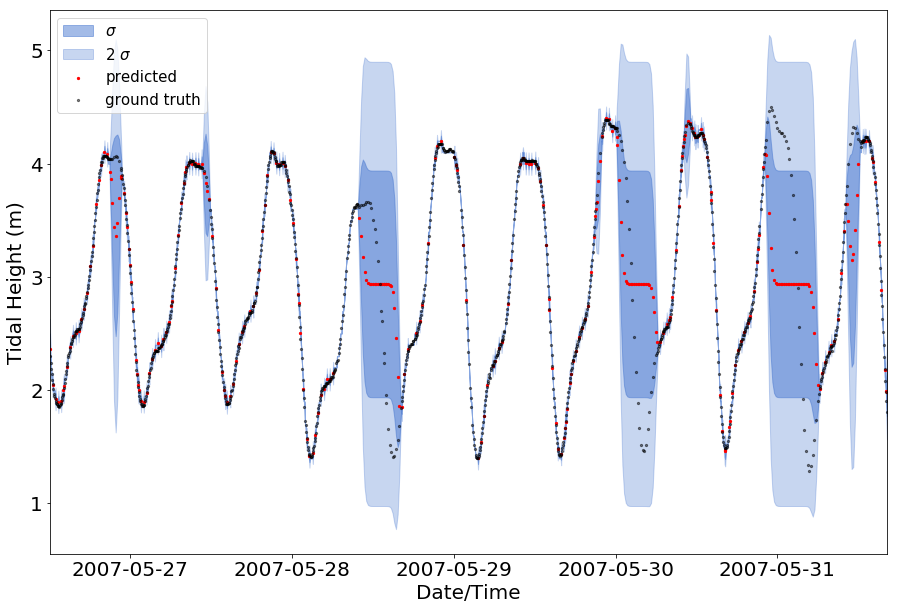

In [18]:
#define posterior predictive mean and var
mupost,sigpost = gp(exp_kernel,[1, 30])
plotter(mupost,sigpost,'exp_weak')

In [14]:
pred_log_likelihood([1,30],exp_kernel,mupost,ttest)

271.6209340486077

### matern + periodic

In [205]:
minimize(factor,[1, 200, 6.3, .5,740],args=(matern_mix),method='L-BFGS-B',bounds = ((1e-10,None),(1e-10,None),(1e-10,None),(1e-10,None),(1e-10,None)))

      fun: -932.3302664993249
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.91499714, 5.106358  , 2.86427166, 1.98226644, 3.03703018])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 192
      nit: 14
   status: 0
  success: True
        x: array([  4.57633962, 198.98584831,   5.55995061,   7.35868281,
       741.3378994 ])

RMSE = 0.053147425954979885
R^2 = 0.9968900515979986


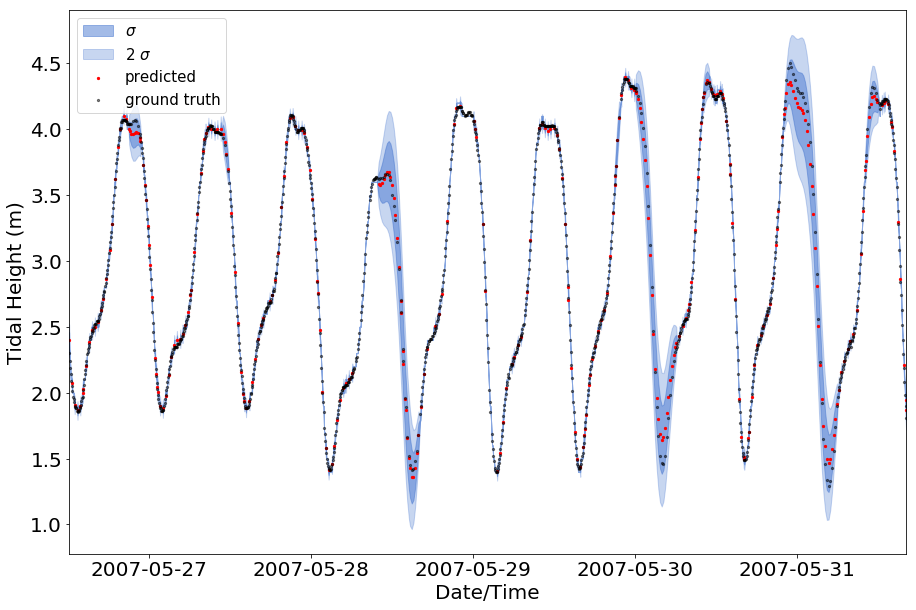

In [19]:
#define posterior predictive mean and var
mupost,sigpost = gp(matern_mix,[.3, 150, 6.3, .5,740])
plotter(mupost,sigpost,'matpper')

In [261]:
pred_log_likelihood([.3, 150, 6.3, .5,740],matern_mix,mupost,ttest)

-581.8489264018208

### MAtern

In [177]:
minimize(factor,[0.35,10],args=(matern),method='L-BFGS-B',bounds = ((1e-10,None),(1e-10,None)))

      fun: -944.5372927627421
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.94259132, -0.0813543 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 105
      nit: 18
   status: 0
  success: True
        x: array([  2.46351321, 128.57300971])

RMSE = 0.3085552993981641
R^2 = 0.8951774472170475


11.20987408293098

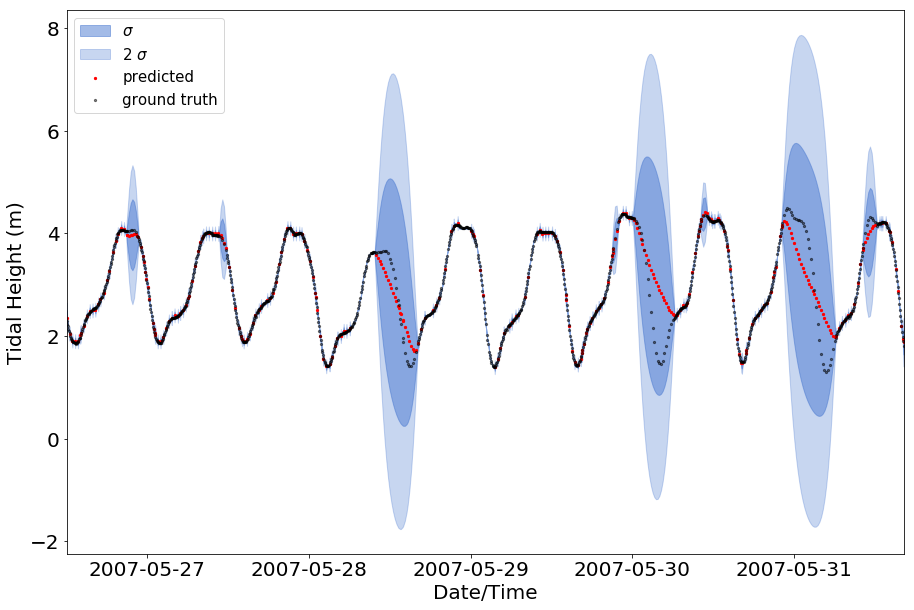

In [20]:
#define posterior predictive mean and var
mupost,sigpost = gp(matern,[2.46, 128.91279916])
plotter(mupost,sigpost,'matern')
pred_log_likelihood([2.46, 128.91279916],matern,mupost,ttest)

### Exp Kernel

In [102]:
minimize(factor,[.1,50],args=(exp_kernel),method='L-BFGS-B',bounds = ((1e-10,None),(1e-10,None)))

      fun: 244078.17641134787
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([191293.73831674, -18557.63548519])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 213
      nit: 7
   status: 2
  success: False
        x: array([12.29276935, 44.86286987])

RMSE = 0.3809562683674689
R^2 = 0.8402139133656238


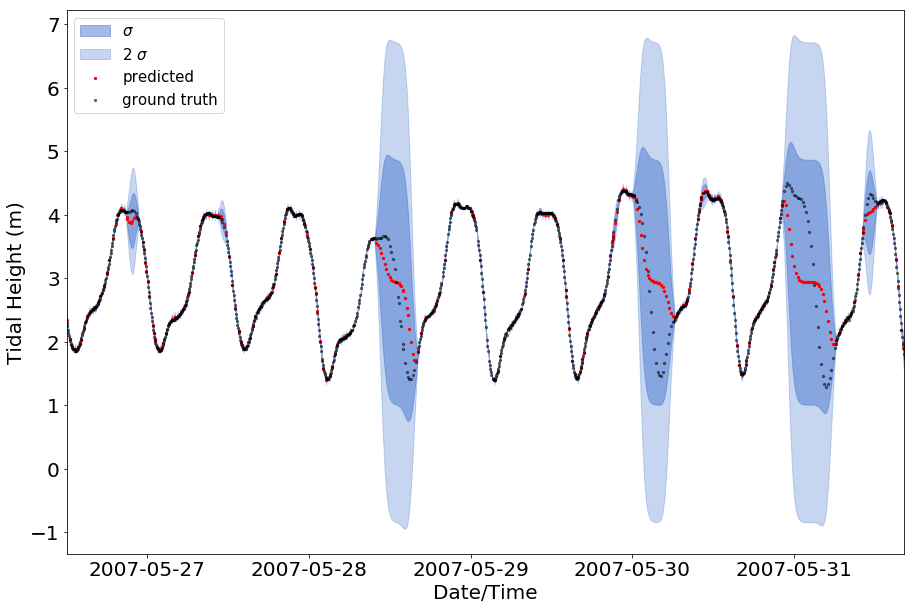

In [21]:
#define posterior predictive mean and var
mupost,sigpost = gp(exp_kernel,[1.9276935, 54.86286987])
plotter(mupost,sigpost,'exp')

In [273]:
pred_log_likelihood([1.9276935, 54.86286987],exp_kernel,mupost,ttest)

-590.6783930630579

### rq kernel

In [274]:
minimize(factor,[4,1,0.5],args=(rq_kernel),method='L-BFGS-B',bounds = ((1e-10,None),(1e-10,None),(1e-10,None)))

      fun: -121.0882887128895
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([4.54747351e-03, 1.09139364e-03, 1.58099363e+02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 428
      nit: 63
   status: 0
  success: True
        x: array([6.72939282e+00, 1.81040398e+00, 1.69879058e-04])

RMSE = 0.4860638798807367
R^2 = 0.7398790023955539


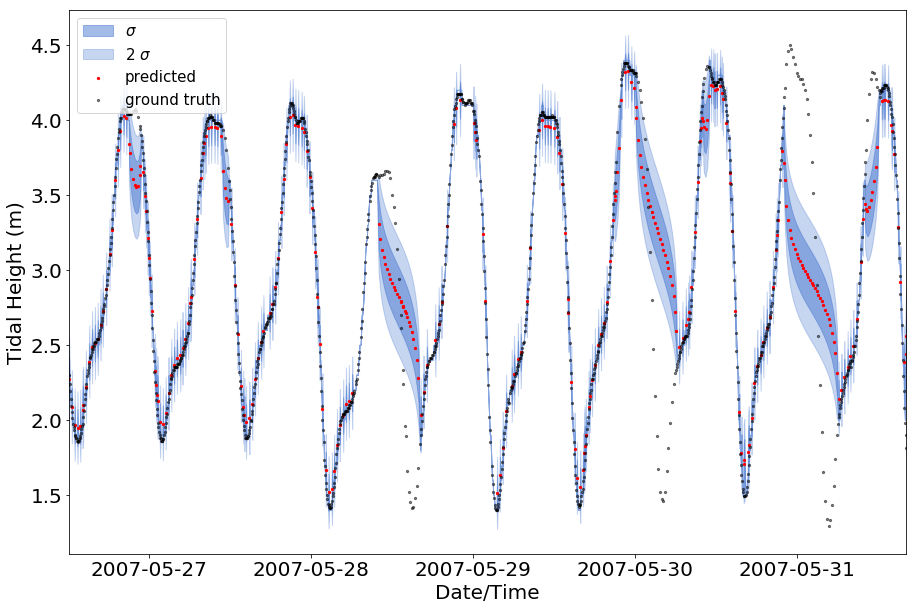

In [22]:
mupost,sigpost = gp(rq_kernel,[4.39282e+00, 1.81040398e+00, 1.69879058e-04])
plotter(mupost,sigpost,'rq_kernel')

In [278]:
pred_log_likelihood([4.39282e+00, 1.81040398e+00, 1.69879058e-04],rq_kernel,mupost,ttest)

455.59154457819756

### Periodic

In [279]:
minimize(factor,[4,1,700],args=(periodic_kernel),method='L-BFGS-B',bounds = ((1e-10,None),(1e-10,None),(1e-10,None)))

      fun: 262109789.04575336
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.56978717e+08,  2.62023431e+08,  1.35597897e+09])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 84
      nit: 0
   status: 2
  success: False
        x: array([  4.,   1., 700.])

RMSE = 0.19450071606913655
R^2 = 0.9583484544173162


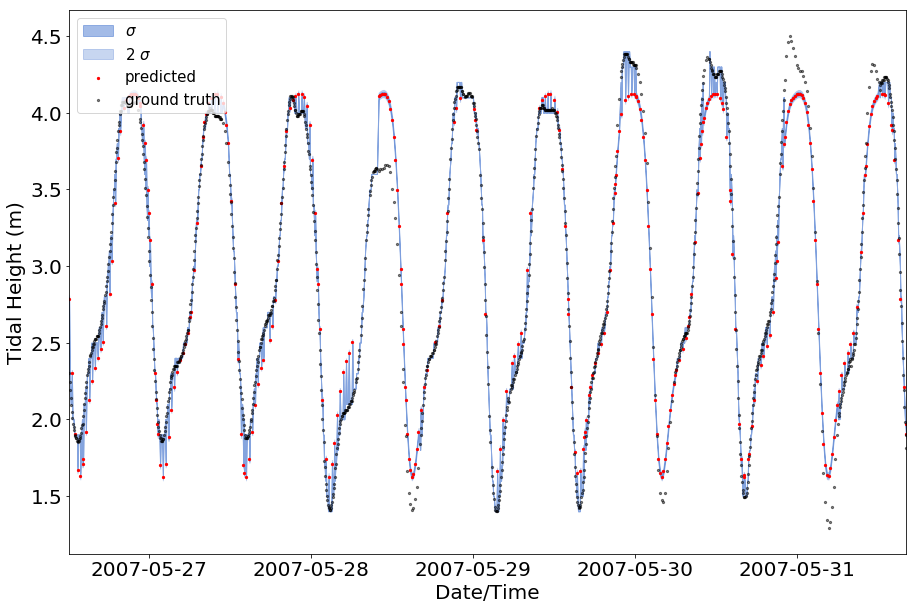

In [23]:
mupost,sigpost = gp(periodic_kernel,[1., 1, 740])
plotter(mupost,sigpost,'periodic_kernel')

In [284]:
pred_log_likelihood([1,1,740],periodic_kernel,mupost,ttest)

-1928.752936533174

#### mix kernel add 1

RMSE = 0.269062864740673
R^2 = 0.9202930417178793


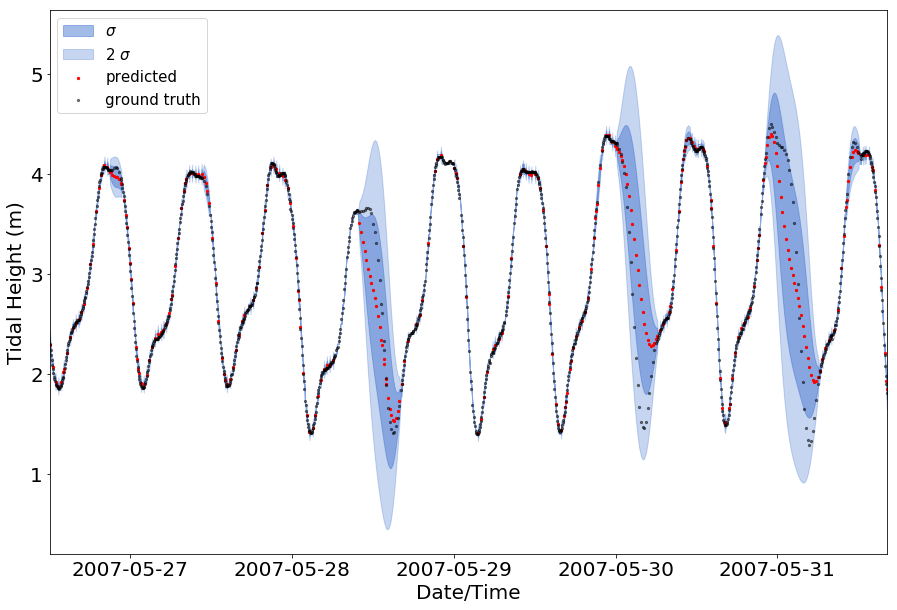

In [24]:
mupost,sigpost = gp(mix_kernel_add1,[9.27242079e-01, 9.70295768e+01, 2.41663781e-04])
plotter(mupost,sigpost,'mixadd1')

In [286]:
pred_log_likelihood([9.27242079e-01, 9.70295768e+01, 2.41663781e-04],mix_kernel_add1,mupost,ttest)

-481.0905985647834

### Mix Kernel add 2

In [306]:
minimize(factor,[8.63150276e-01, 9.58366196e+01, 2.00568323e+00, 6.65202821e-02,5.15949295e-05],args=(mix_kernel_add2),method='L-BFGS-B',bounds = ((1e-10,None),(1e-10,None),(1e-10,None),(1e-10,None),(1e-10,None)))

      fun: -3235.69468097352
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.07124833e+00, -4.25188773e-02, -3.33056960e-01,  5.34328137e-02,
        4.16075181e+02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 90
      nit: 2
   status: 0
  success: True
        x: array([8.63150276e-01, 9.58366196e+01, 2.00568323e+00, 6.65202821e-02,
       5.16505735e-05])

In [25]:
mupost,sigpost = gp(mix_kernel_add2,[8.63150276e-01, 9.58366196e+01, 2.00568323e+00, 6.65202821e-02,5.16505735e-05])
plotter(mupost,sigpost)

TypeError: plotter() missing 1 required positional argument: 'name'

### Mix kernel add 3

In [213]:
minimize(factor,[8.63150276e-01, 9.58366196e+01, 2.00568323e+00, 6.65202821e-02,5.15949295e-05,1,50],args=(mix_kernel_add3),method='L-BFGS-B',bounds = ((1e-10,None),(1e-10,None),(1e-10,None),(1e-10,None),(1e-10,None),(1e-10,None),(1e-10,None)))

C:\Users\Shaan Desai\Anaconda3\lib\site-packages\ipykernel\__main__.py:57: RuntimeWarning: divide by zero encountered in true_divide


      fun: -3229.600664180447
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.48068466e+01,  1.38970790e-01,  6.87550710e+00,  5.24414645e-01,
        1.17366056e+05,  6.82771315e+00,  3.15594662e-02])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 552
      nit: 21
   status: 0
  success: True
        x: array([8.20940097e-01, 9.97681842e+01, 1.88347229e+00, 1.59700263e-03,
       5.98041151e-05, 9.44394004e-01, 7.91686263e+02])

RMSE = 0.29785068547481275
R^2 = 0.9023244376353533


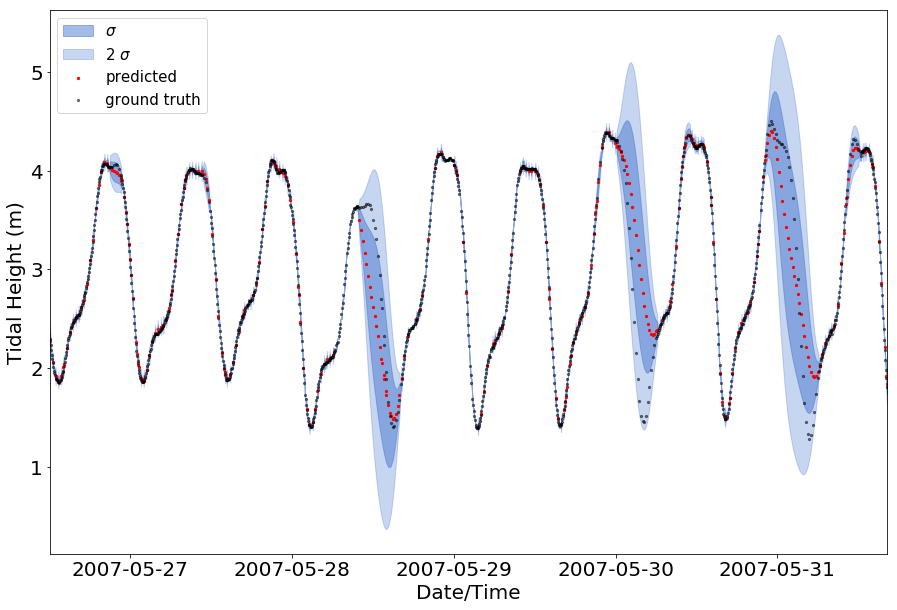

In [26]:
mupost,sigpost = gp(mix_kernel_add3,[8.20940097e-01, 9.97681842e+01, 1.88347229e+00, 1.59700263e-03,5.98041151e-05, 9.44394004e-01, 7.91686263e+02])
plotter(mupost,sigpost,'mixadd3')

In [289]:
pred_log_likelihood([8.20940097e-01, 9.97681842e+01, 1.88347229e+00, 1.59700263e-03,5.98041151e-05, 9.44394004e-01, 7.91686263e+02],mix_kernel_add3,mupost,ttest)

-479.3394485337645

### mix kernel mult 2

RMSE = 0.3131900891503139
R^2 = 0.892004730306755


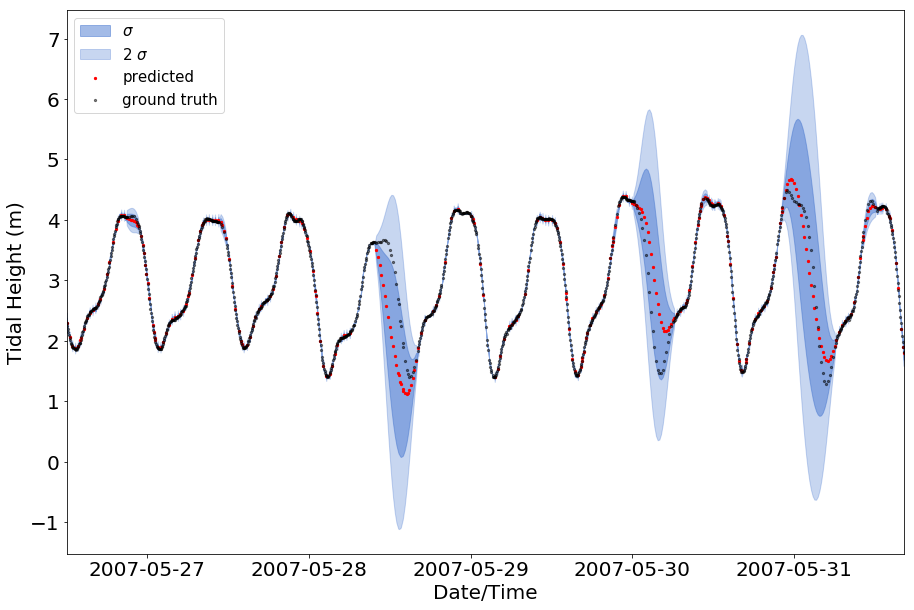

In [27]:
mupost,sigpost = gp(mix_kernel_mult2,[6.24550227e+01, 1.21416720e+02, 5.49867651e-03, 1.67822254e+00,5.45235596e-05, 3.76130621e+01, 1.43044265e+03, 1.50326339e-01,1.16370389e+02, 1.13657811e+02])
plotter(mupost,sigpost,'mixmult2')

In [292]:
pred_log_likelihood([6.24550227e+01, 1.21416720e+02, 5.49867651e-03, 1.67822254e+00,5.45235596e-05, 3.76130621e+01, 1.43044265e+03, 1.50326339e-01,1.16370389e+02, 1.13657811e+02],mix_kernel_mult3,mupost,ttest)

1842.136821265145

#### Mix kernel mult 0

C:\Users\Shaan Desai\Anaconda3\lib\site-packages\ipykernel\__main__.py:126: RuntimeWarning: invalid value encountered in sqrt


RMSE is = 0.9670001472358426
2 Norm is = 332.5936567738645
R^2 = -0.029536605995104548


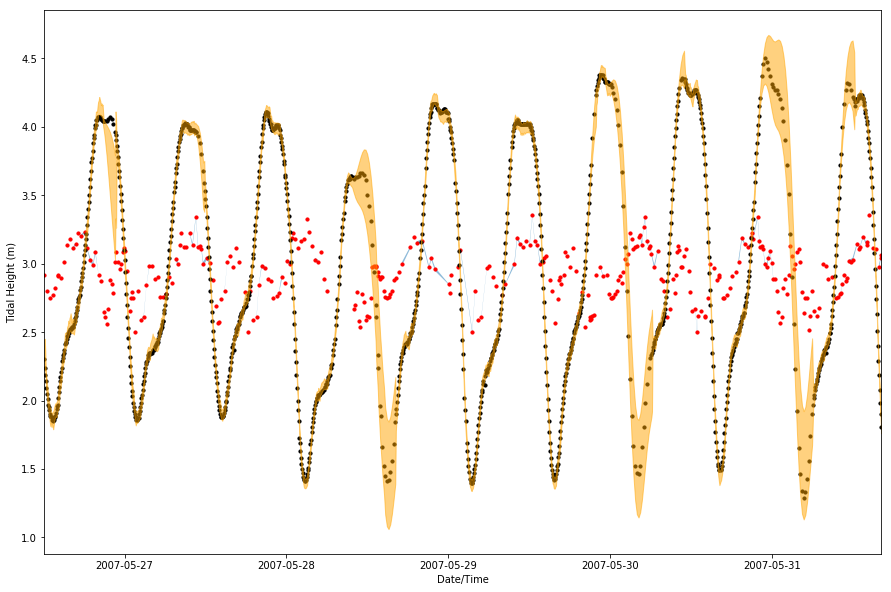

In [230]:
mupost,sigpost = gp(periodic_kernel,[10,.3,1000])
plotter(mupost,sigpost)

In [280]:
minimize(factor,[.1, 800, 10,.25,700],args=(mix_kernel_mult0),method='L-BFGS-B',bounds = ((1e-10,None),(1e-10,None),(1e-10,None),(1e-10,None),(1e-10,None)))

      fun: -1250.7148244857292
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.46288733, -0.43487489,  0.06980372,  2.16703029, -0.87034095])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 666
      nit: 43
   status: 0
  success: True
        x: array([7.92766846e-02, 7.95974645e+02, 1.92484756e+01, 7.98143258e-02,
       7.02908590e+02])

RMSE = 0.267492204518334
R^2 = 0.9212209077156508


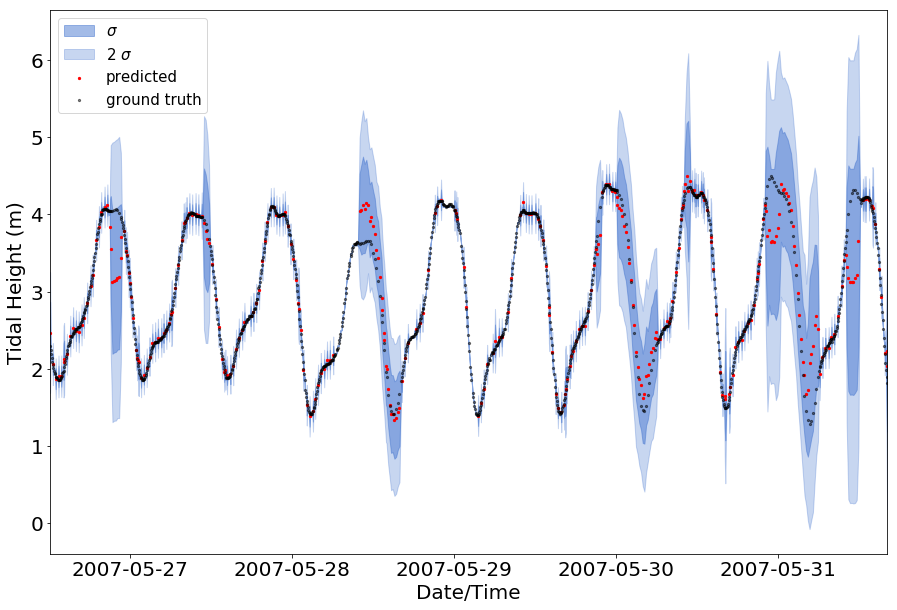

In [28]:
mupost,sigpost = gp(mix_kernel_mult0,[7.92766846e-02, 7.95974645e+02, 1.92484756e+01, 7.98143258e-02,7.02908590e+02])
plotter(mupost,sigpost,'mult0')

In [295]:
pred_log_likelihood([7.92766846e-02, 7.95974645e+02, 1.92484756e+01, 7.98143258e-02,7.02908590e+02],mix_kernel_mult0,mupost,ttest)

631.7250828136071

### Mix kernel mult 3

In [19]:
minimize(factor,[.1, 800, 10,.25,700,1,1,1],args=(mix_kernel_mult3),method='L-BFGS-B',bounds = ((1e-10,None),(1e-10,None),(1e-10,None),(1e-10,None),(1e-10,None),(1e-10,None),(1e-10,None),(1e-10,None)))

      fun: -3276.319942319815
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.33492142, -0.05984475,  0.0041382 , -0.08126335, -0.02273737,
        0.11013981,  0.03919922, -0.01145963])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1386
      nit: 90
   status: 0
  success: True
        x: array([1.60354866e-01, 8.02228895e+02, 9.54115609e+00, 1.17022058e+00,
       7.37474497e+02, 3.55505032e-02, 8.45143604e-01, 4.16946366e-01])

RMSE = 0.10256674496767174
R^2 = 0.9884175120074326


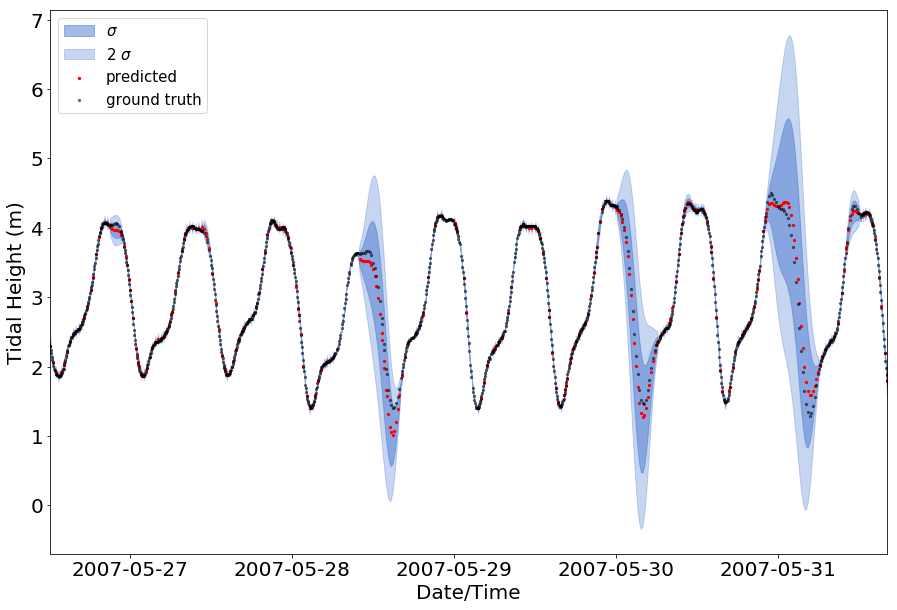

In [29]:
mupost,sigpost = gp(mix_kernel_mult3,[3.60354866e-01, 8.02228895e+02, 9.54115609e+00, 1.17022058e+00,7.37474497e+02, 3.55505032e-02, 8.45143604e-01, 4.16946366e-01])
plotter(mupost,sigpost,'mixmult3')

In [297]:
pred_log_likelihood([3.60354866e-01, 8.02228895e+02, 9.54115609e+00, 1.17022058e+00,7.37474497e+02, 3.55505032e-02, 8.45143604e-01, 4.16946366e-01],mix_kernel_mult3,mupost,ttest)

-478.7461033113844

# II. Sequential Data Predictions

In [73]:
#parse data
df = pd.read_csv('sotonmet.txt',parse_dates=[0,2])
df.drop_duplicates(subset = ['Reading Date and Time (ISO)'],keep='first',inplace=True)
df = df.iloc[1:]
y = df[['Tide height (m)']]
t = df[['Reading Date and Time (ISO)']]

# extract training/test data
ytest = y[y['Tide height (m)'].isnull()].values
ytdrain = y[y['Tide height (m)'].notnull()].index

ytrain = y[y['Tide height (m)'].notnull()].values
ttrain = t[y['Tide height (m)'].notnull()].values
ttest = t[y['Tide height (m)'].isnull()].values
y_test_true = df[df['Tide height (m)'].isnull()][['True tide height (m)']]
y_true = df[['True tide height (m)']]

indmu = df[['Independent tide height prediction (m)']].values
indsd = df[['Independent tide height deviation (m)']].values

dmu = df[['Dependent tide height prediction (m)']].values
dsd = df[['Dependent tide height deviation (m)']].values


In [74]:
def sequencer2(start):
    tt = t.values.ravel()
    yy = y.values.ravel()
    
    def gp_seq(main_kernel,xpar,tend,add,currt,curry):
        trainer = currt
        ytrainer = curry
        tester = tt[tend]
        K = cov_mat(main_kernel,trainer,trainer,xpar) + 1e-2*np.eye(len(ytrainer))
        K_inv = np.linalg.inv(K)
        K_star = cov_mat(main_kernel,trainer,tester,xpar)
        K_star_star = cov_mat(main_kernel,tester,tester,xpar)
        #define posterior predictive mean and var
        mupost = ytrainer.mean()*np.ones((1,1)) + np.dot(K_star,K_inv).dot(ytrainer-ytrainer.mean())
        sigpost = K_star_star - np.dot(np.dot(K_star,K_inv),K_star.T)
        return mupost,sigpost
    
    ctr = 0
    collectorm = []
    collectors = []
    currt = np.array([tt[0]])
    curry = np.array([yy[0]])
    for i in range(1,len(tt)):
        m,s = gp_seq(mix_kernel_mult3,[1.60354866e-01, 8.02228895e+02, 9.54115609e+00, 1.17022058e+00,7.37474497e+02, 3.55505032e-02, 8.45143604e-01, 4.16946366e-01],i,1,currt,curry)
        collectorm.append(m)
        collectors.append(s)
        #print(yy[i])
        if np.isnan(yy[i]) == False:
            currt = np.append(currt,tt[i])
            curry = np.append(curry,yy[i])
        if i > 100:
            currt = currt[-50:]
            curry = curry[-50:]
        ctr+=1
    return collectorm,collectors

In [75]:
a,b = sequencer2(10)


In [76]:
a = np.array(a).ravel()
b = np.array(b).ravel()

In [77]:
a.shape

(1255,)

In [78]:
def newplotter(a,b,starter):
    plt.figure(figsize=(15,10))
    err = b.ravel()
    plt.fill_between(t.values.ravel()[starter:], a.flatten()-err, a.flatten()+err,alpha=0.5,color='#4878D0',label='$\sigma$')
    plt.scatter(t.values.ravel(),y_true.values.ravel(),s = 0.5,color='black',label='ground truth')
    
    plt.xlabel('Date/Time',fontsize=20)
    plt.ylabel('Tidal Height (m)',fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=15)
    plt.savefig('ts2.pdf',bbox_inches='tight')

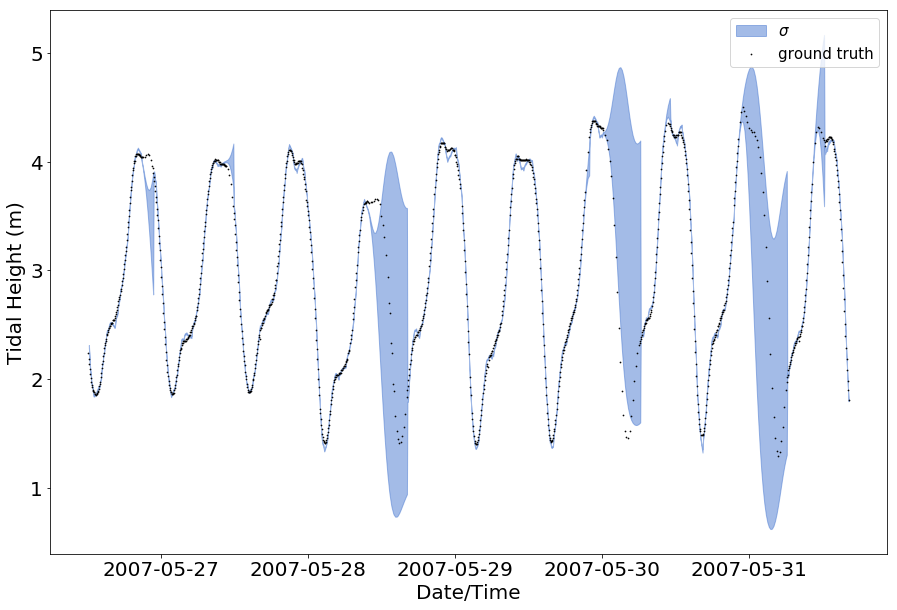

In [79]:
newplotter(a,b,1)
#plt.ylim([0,6])

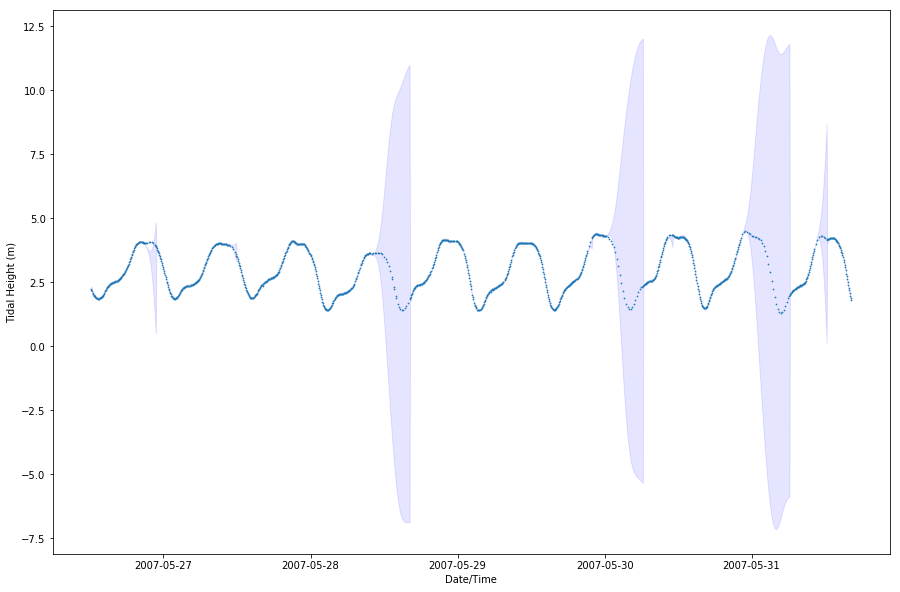

In [82]:
newplotter(a,b,1)

In [84]:
a,b = sequencer2(10)


In [85]:
a = np.array(a).ravel()
b = np.array(b).ravel()

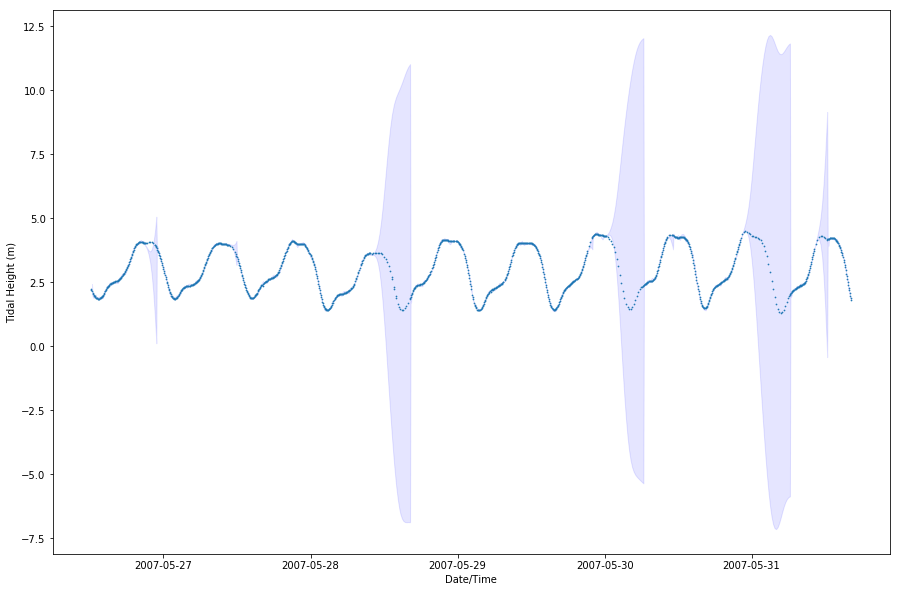

In [86]:
newplotter(a,b,2)